In [159]:
library(readxl)
library(tseries)
library(forecast)
library(TSA)
library(dplyr)
library(car)
library(fitdistrplus)
library(nortest)
library(ggplot2)

#opts_chunk$set(fig.align = 'center')
#theme_set(theme_bw())

* Поработаем с данными, в нашем варианте необходимо выбрать временной период с 2010 по 2015 год, убрано лишнее руками и сохраненно в формате csv

In [160]:
data <- read.csv("data.csv")
head(data)
tail(data)

,X,Date,Gasoline_Prices
,<int>,<chr>,<dbl>
1,1012,2010-01-04,2.718
2,1013,2010-01-11,2.804
3,1014,2010-01-18,2.793
4,1015,2010-01-25,2.760
5,1016,2010-02-01,2.717
6,1017,2010-02-08,2.707


,X,Date,Gasoline_Prices
,<int>,<chr>,<dbl>
256,1267,2014-11-24,2.907
257,1268,2014-12-01,2.864
258,1269,2014-12-08,2.767
259,1270,2014-12-15,2.643
260,1271,2014-12-22,2.496
261,1272,2014-12-29,2.392


# ИССЛЕДОВАНИЕ СТАЦИОНАРНОСТИ

* Создадим временной ряд и исследуем его на стационарность.

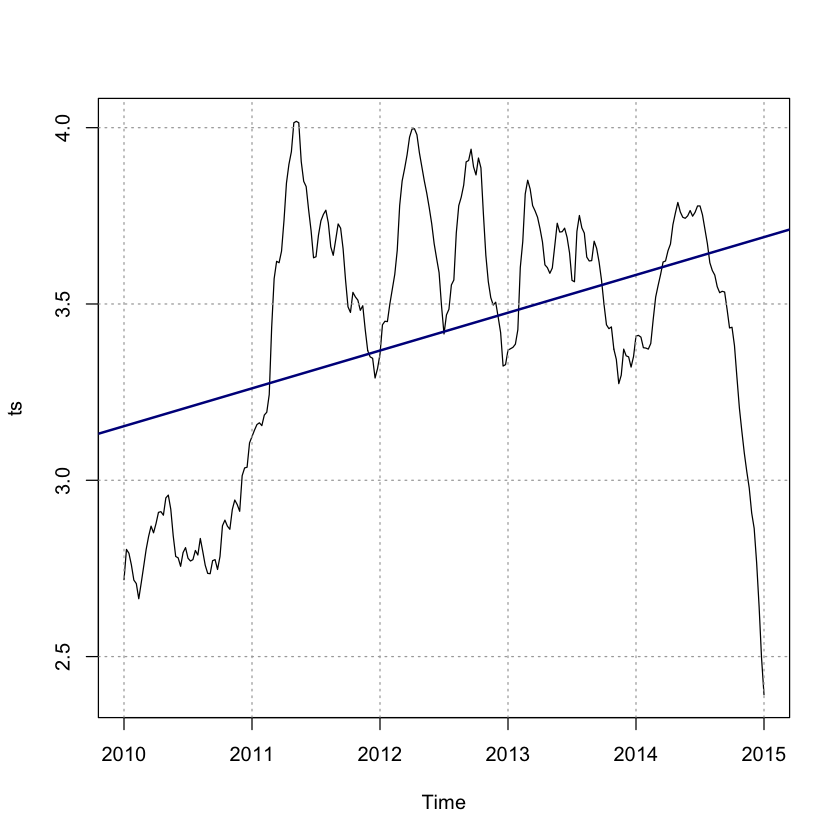

In [161]:
ts <- ts(data$Gasoline_Prices, start = c(2010, 1), frequency = 52)
plot(ts)
abline(v = (seq(2010, 2015, by = 1)), col = 'darkgray', lty = 'dotted')
abline(h = (seq(2.5, 4, by = 0.5)), col = 'darkgray', lty = 'dotted')
abline(reg = lm(ts ~ time(ts)), col = 'darkblue', lw = 2)

* Судя по графику - гипотеза нестационарности ряда
* Тест Дики-Фуллера.

In [162]:
adf.test(ts)


	Augmented Dickey-Fuller Test

data:  ts
Dickey-Fuller = -1.2639, Lag order = 6, p-value = 0.8859
alternative hypothesis: stationary


- Гипотеза не отвергнута (p-value высок)
- Строим график приращений ряда (начального)

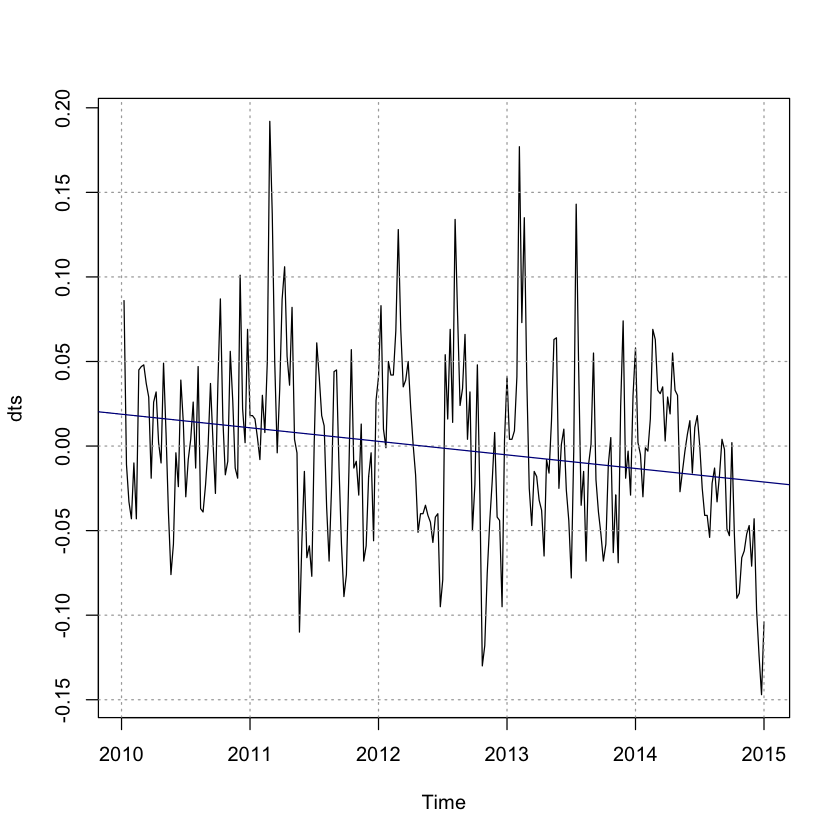

In [163]:
dts <- diff(ts)
plot(dts)
abline(v = (seq(2010, 2015, by = 1)), col = 'darkgray', lty = 'dotted')
abline(h = (seq(-0.15, 0.15, by = 0.05)), col = 'darkgray', lty = 'dotted')
abline(reg = lm(dts ~ time(dts)), col = 'darkblue')

In [164]:
adf.test(dts)

Warning message in adf.test(dts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  dts
Dickey-Fuller = -4.3526, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


- Гипотеза о нестационарности ряда приращений отвергается.

# ACF и PACF ряда приращений

- Из-за версии R есть особенность - возможно отсечение 1 стремления значения (далее роли не сыграет)

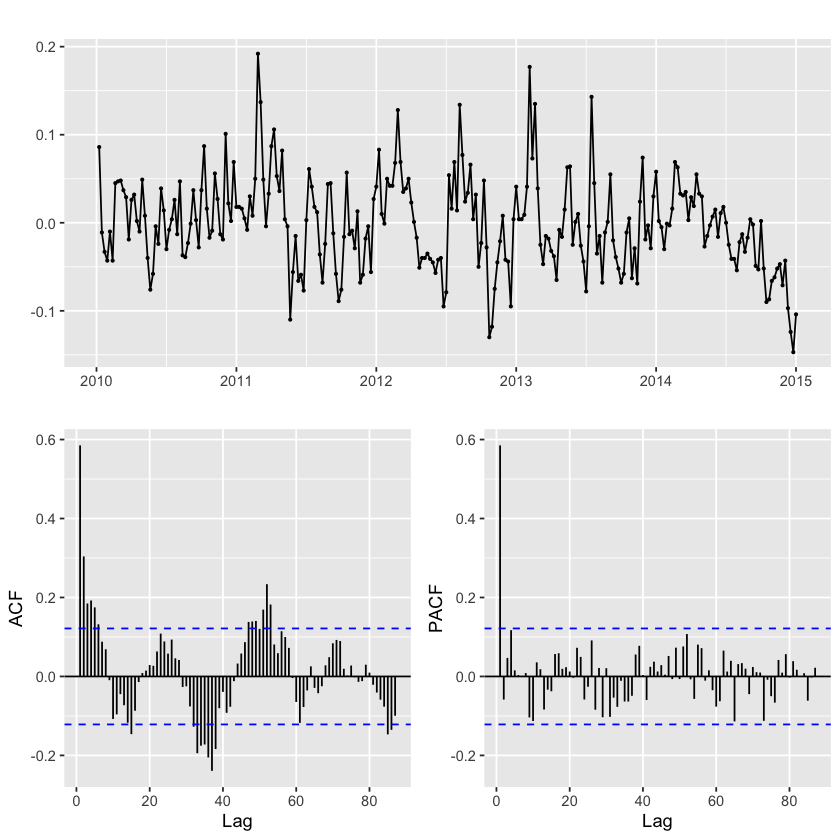

In [165]:
ggtsdisplay(dts)

* Для определения несезонной составляющей AR модели посмотрим PACF ближе

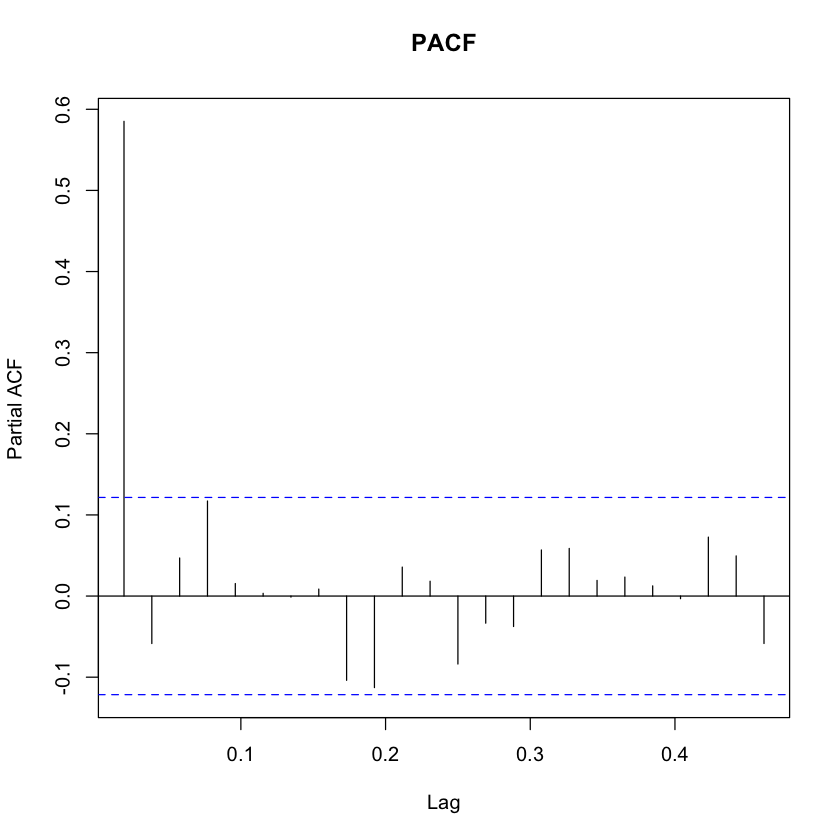

In [166]:
pacf(dts, main = 'PACF')

* Предпологаем годовую сезонность (1 значение -> пунктиру)
- Сезонный порядок = 1 ; Несезонный порядок равен 1 | 4

# СРАВНЕНИЕ МОДЕЛЕЙ

In [167]:
ar<- arima(dts, order = c(1, 0, 0),method="ML")
sar <- arima(dts, order = c(1, 0, 0), seasonal = list(order = c(1, 0, 0), period = 52))
ar$aic

[1] -904.593

In [168]:
ar<- arima(dts, order = c(4, 0, 0),method="ML")
sar <- arima(dts, order = c(1, 0, 0), seasonal = list(order = c(1, 0, 0), period = 52))
ar$aic

[1] -903.9832

- ARIMA(1,0,0) лучше

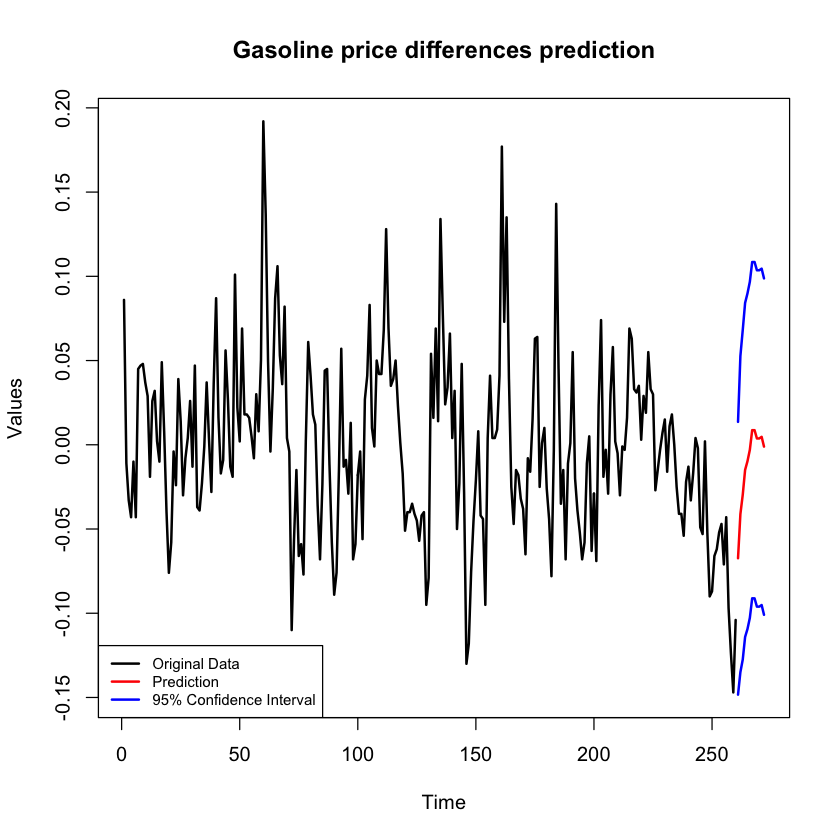

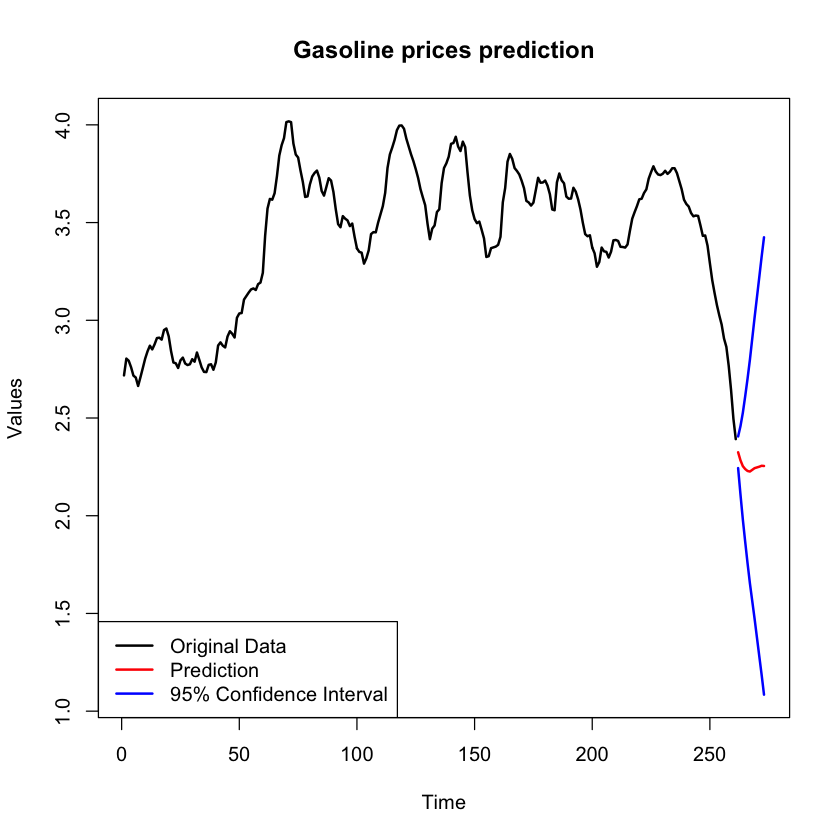

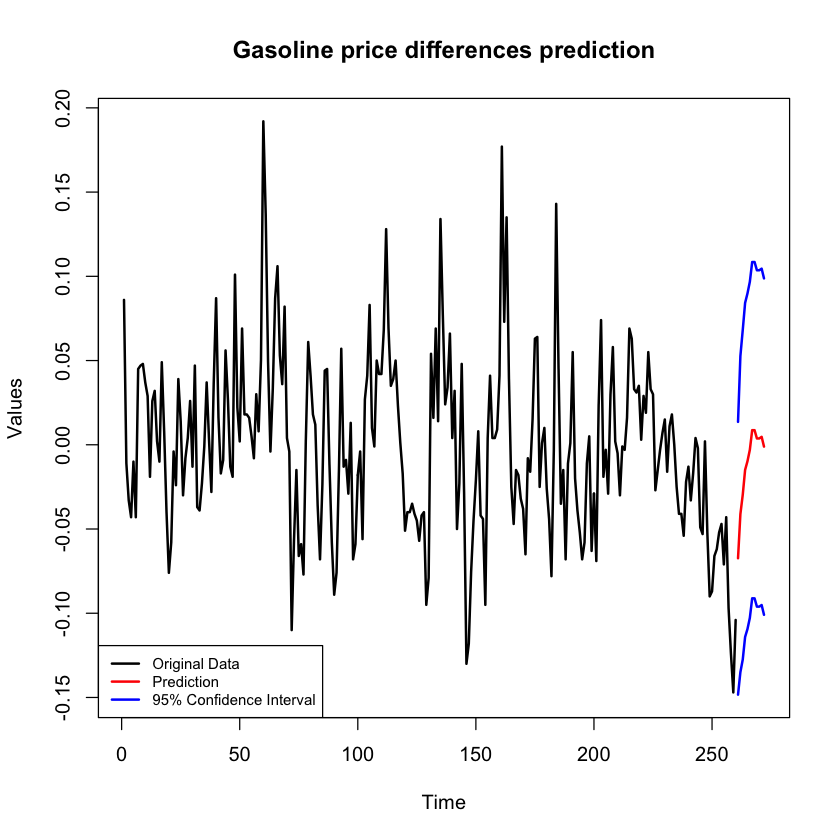

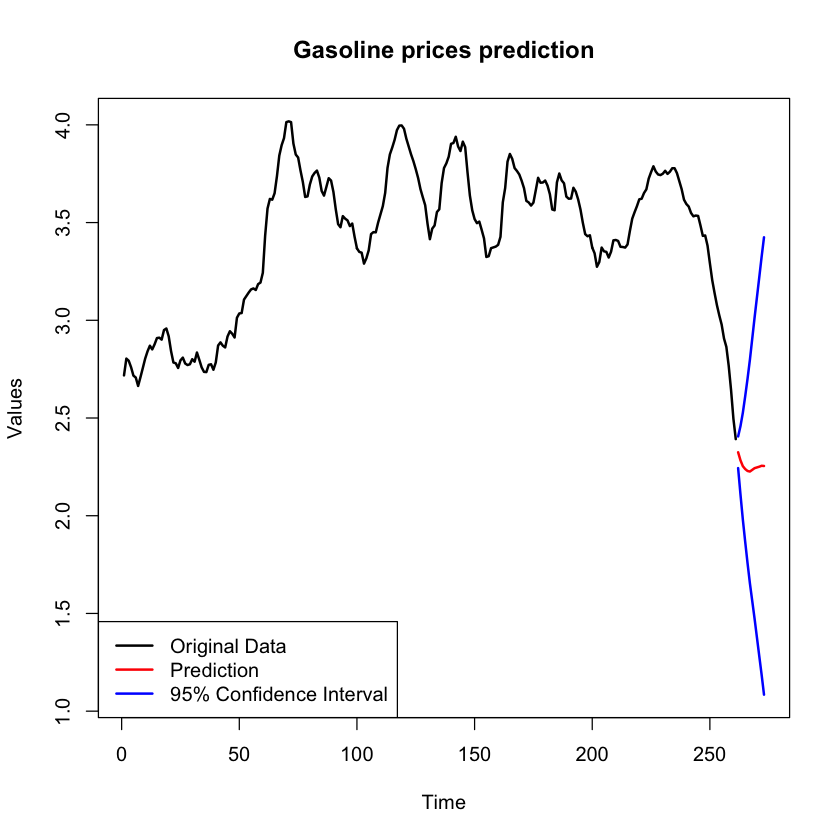

In [169]:
FORECAST_RANGE <- 12

m1 <- arima(dts, order = c(1,0,0), 
            seasonal = list(order = c(1,0,0), period = 52), method = 'ML')
f1 <- predict(m1, n.ahead = FORECAST_RANGE)
lci <- f1$pred - qnorm(0.025,0,1)*f1$se
uci <- f1$pred + qnorm(0.025,0,1)*f1$se

plot_diff1 <- data.frame(Original_data=c(dts, rep(NA, FORECAST_RANGE)), 
                        Prediction = c(rep(NA, length(dts)), f1$pred), 
                        Upper_CI = c(rep(NA, length(dts)), uci), 
                        Lower_CI = c(rep(NA, length(dts)), lci))
matplot(plot_diff1, type = 'l', pch = 20, lty = 1,
        col = c('black', 'red', 'blue', 'blue'), lwd = 2,
        xlab = 'Time', ylab = 'Values',
        main = 'Gasoline price differences prediction')
legend('bottomleft', c('Original Data', 'Prediction', '95% Confidence Interval'),
       col = c('black', 'red', 'blue'), lwd = 2, cex = 0.75)
first_value <- ts[1]
last_value <- ts[length(ts)]
plot_orig1 <- data.frame(Original_data = c(diffinv(dts, lag = 1, differences = 1, first_value), 
                                           rep(NA, FORECAST_RANGE)), 
                        Prediction = c(rep(NA, length(ts)), 
                                       diffinv(f1$pred, lag = 1, differences = 1, last_value)[2:13]), 
                        Upper_CI = c(rep(NA, length(ts)), 
                                     diffinv(uci, lag = 1, differences = 1, last_value)[2:13]), 
                        Lower_CI = c(rep(NA, length(ts)), 
                                     diffinv(lci, lag = 1, differences = 1, last_value)[2:13]))
matplot(plot_orig1, type = 'l', pch = 20, lty = 1, 
        col = c('black', 'red', 'blue', 'blue'),
        lwd = 2, xlab = 'Time', ylab = 'Values',
        main = 'Gasoline prices prediction')
legend('bottomleft', c('Original Data', 'Prediction', '95% Confidence Interval'),
       col = c('black', 'red', 'blue'), lwd = 2)
m2 <- arima(dts, order = c(4,0,0), 
            seasonal = list(order = c(1,0,0), period = 52), method = 'ML')
f2 <- predict(m1, n.ahead = FORECAST_RANGE)
lci <- f2$pred - qnorm(0.025,0,1)*f2$se
uci <- f2$pred + qnorm(0.025,0,1)*f2$se

plot_diff2 <- data.frame(Original_data=c(dts, rep(NA, FORECAST_RANGE)), 
                        Prediction = c(rep(NA, length(dts)), f2$pred), 
                        Upper_CI = c(rep(NA, length(dts)), uci), 
                        Lower_CI = c(rep(NA, length(dts)), lci))
matplot(plot_diff2, type = 'l', pch = 20, lty = 1,
        col = c('black', 'red', 'blue', 'blue'),
        lwd = 2, xlab = 'Time', ylab = 'Values',
        main = 'Gasoline price differences prediction')
legend('bottomleft', c('Original Data', 'Prediction', '95% Confidence Interval'),
       col = c('black', 'red', 'blue'), lwd = 2, cex = 0.75)
first_value <- ts[1]
last_value <- ts[length(ts)]
plot_orig2 <- data.frame(Original_data = c(diffinv(dts, lag = 1, differences = 1, first_value), 
                                           rep(NA, FORECAST_RANGE)), 
                        Prediction = c(rep(NA, length(ts)), 
                                       diffinv(f2$pred, lag = 1, differences = 1, last_value)[2:13]), 
                        Upper_CI = c(rep(NA, length(ts)), 
                                     diffinv(uci, lag = 1, differences = 1, last_value)[2:13]), 
                        Lower_CI = c(rep(NA, length(ts)), 
                                     diffinv(lci, lag = 1, differences = 1, last_value)[2:13]))
matplot(plot_orig1, type = 'l', pch = 20, lty = 1, 
        col = c('black', 'red', 'blue', 'blue'),
        lwd = 2, xlab = 'Time', ylab = 'Values',
        main = 'Gasoline prices prediction')
legend('bottomleft', c('Original Data', 'Prediction', '95% Confidence Interval'),
       col = c('black', 'red', 'blue'), lwd = 2)

- Визуально одинаково, но мы уже проверили AIC выше

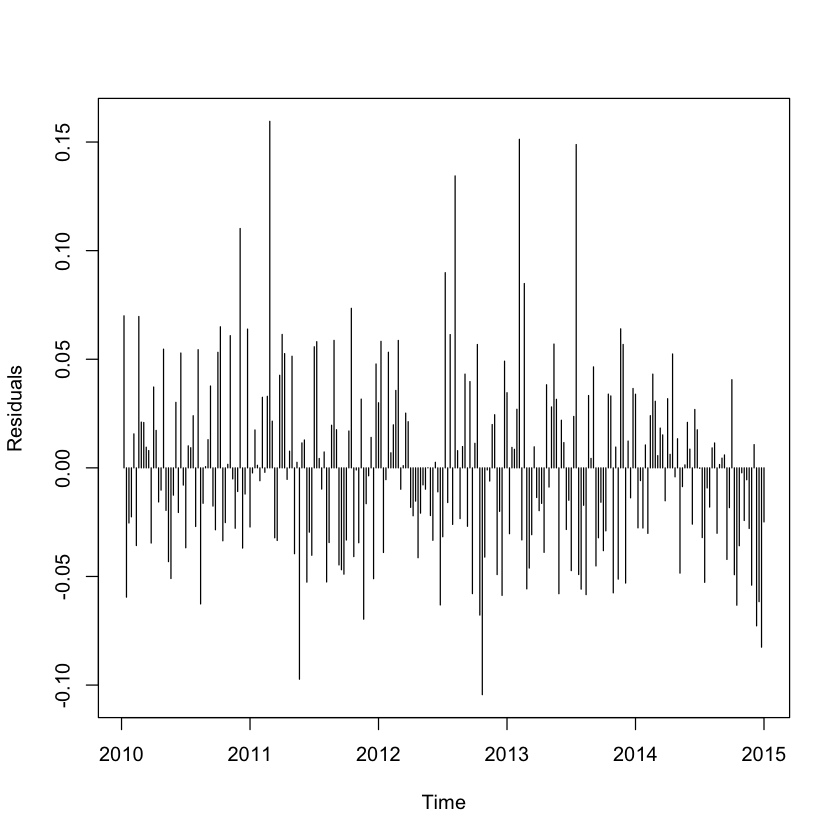

In [170]:
res <- sar$residuals
plot(res, ylab = 'Residuals', type = 'h')

In [171]:
Box.test(res, lag = 52, type = 'Ljung-Box', fitdf = length(coef(m1)))


	Box-Ljung test

data:  res
X-squared = 43.466, df = 49, p-value = 0.6962


- Тест Льюнг-Бокса - гипотезу о случайности остатков

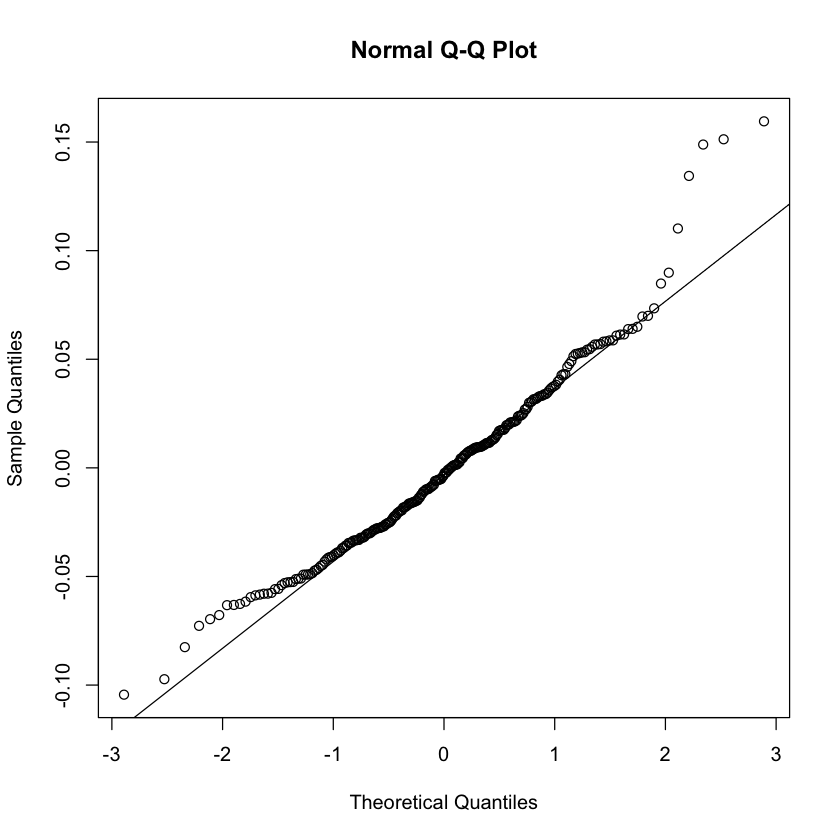

[1]  60 161

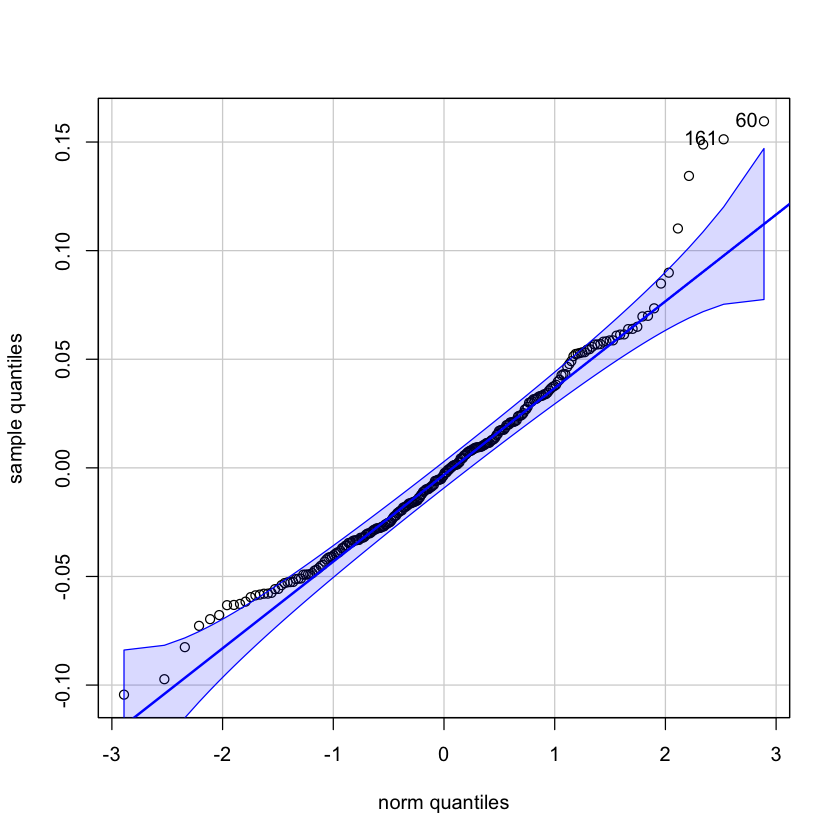

In [172]:
qqnorm(res)
qqline(res)
qqPlot(res, ylab = 'sample quantiles')

- По графику qq-plot остатки похожи на нормально распределенные

In [109]:
RATIO <- 0.7
tr_index <- sample(1:length(res), length(res)*RATIO)
train_res <- res[tr_index]
test_res <- res[-tr_index]
fd_train <- fitdist(train_res, 'norm')
ks.test(test_res, 'pnorm', fd_train$estimate[1], fd_train$estimate[2])


	One-sample Kolmogorov-Smirnov test

data:  test_res
D = 0.07788, p-value = 0.7018
alternative hypothesis: two-sided


- Тест Колмогорова-Смирнова подтверждает нормальность остатков

- Можно сделать вывод, что модель построена хорошо.

# ГРАФИКИ СПЕКТРАЛЬНОЙ ПЛОТНОСТИ

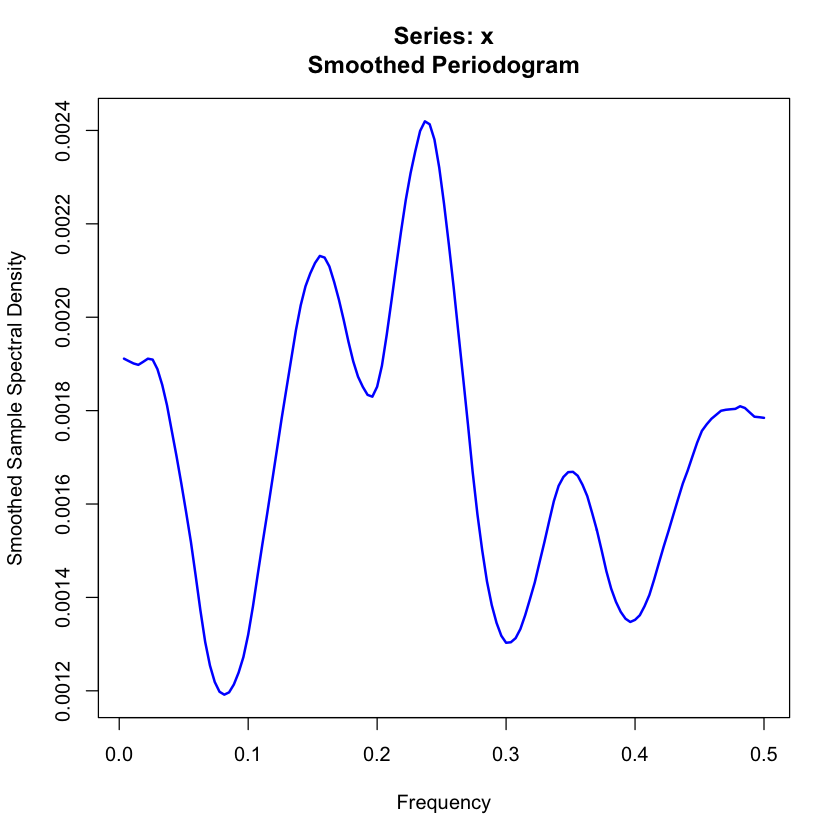

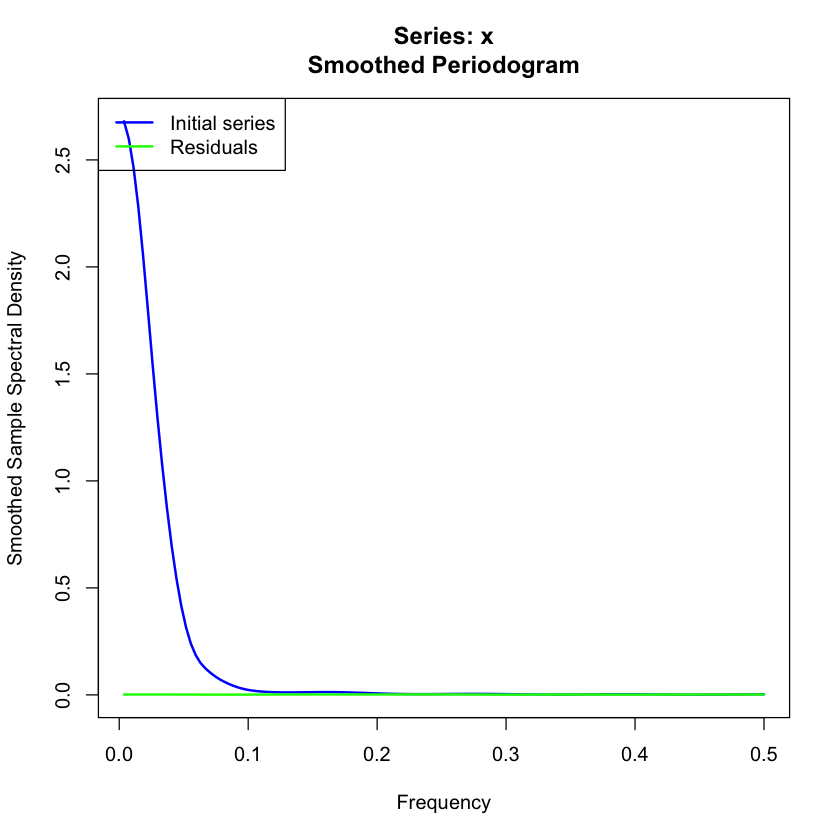

In [173]:
k3<- kernel('daniell',c(5,5,5))
sp=spec(res,kernel=k3,log='no',sub='',xlab='Frequency',
        ylab='Smoothed Sample Spectral Density',col = "blue",lwd = 2)
spy=spec(ts,kernel=k3,log='no',sub='',xlab='Frequency',
         ylab='Smoothed Sample Spectral Density',col = "blue",lwd = 2)
lines(sp$freq,sp$spec,col='green',lwd=2)
legend("topleft",c("Initial series","Residuals"),lwd = 2,col=c("blue","green"))

- Сравнение с исходным и с остатками после удаления модели

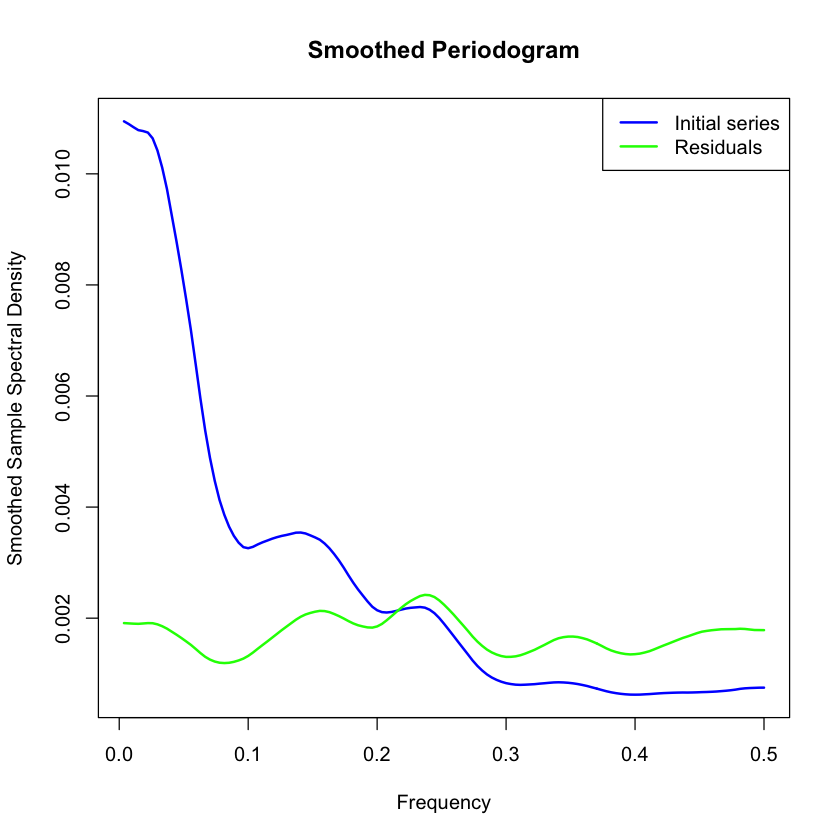

In [174]:
k3 <- kernel('daniell', c(5,5,5))
s_res <- spec(res, kernel = k3, log = 'no', sub = '', plot = FALSE)
s <- spec(dts, kernel = k3, log = 'no', sub = '', col = 'blue', lwd = 2,
     xlab = 'Frequency', ylab = 'Smoothed Sample Spectral Density',
     main = 'Smoothed Periodogram', ylim=)
lines(s_res$freq, s_res$spec, col = 'green', lwd = 2)
legend('topright', c('Initial series', 'Residuals'), lwd = 2, 
       col = c('blue', 'green'))

- Ближе к white noise - белому шуму, значит модель учитывает закономерности

# ПРЕДСКАЗАНИЕ ПО МОДЕЛИ ХОЛЬТА-ВИНТЕРСА

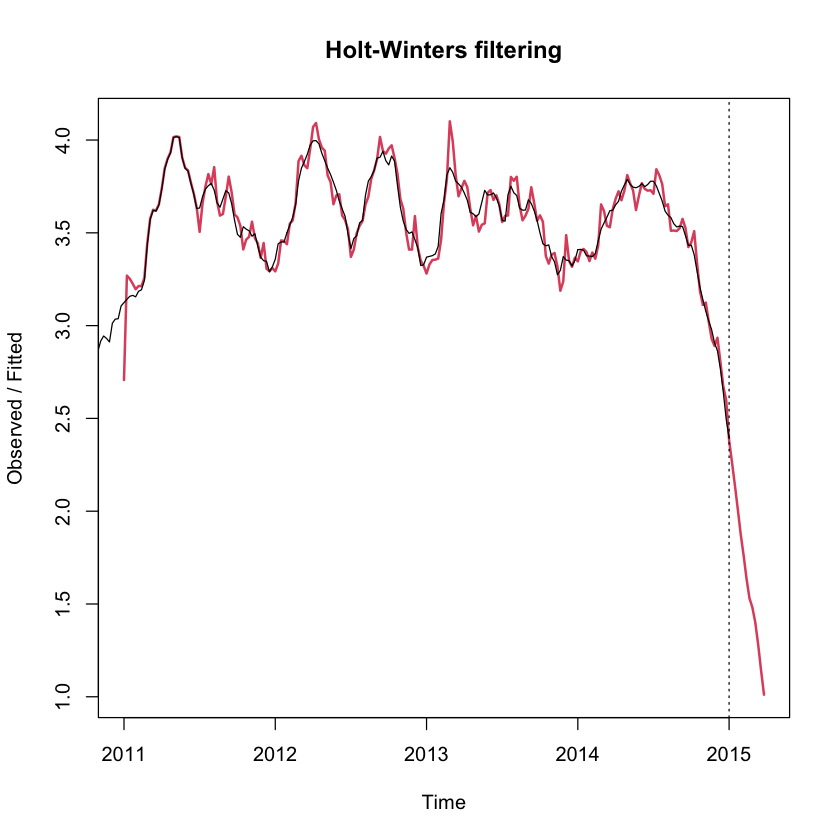

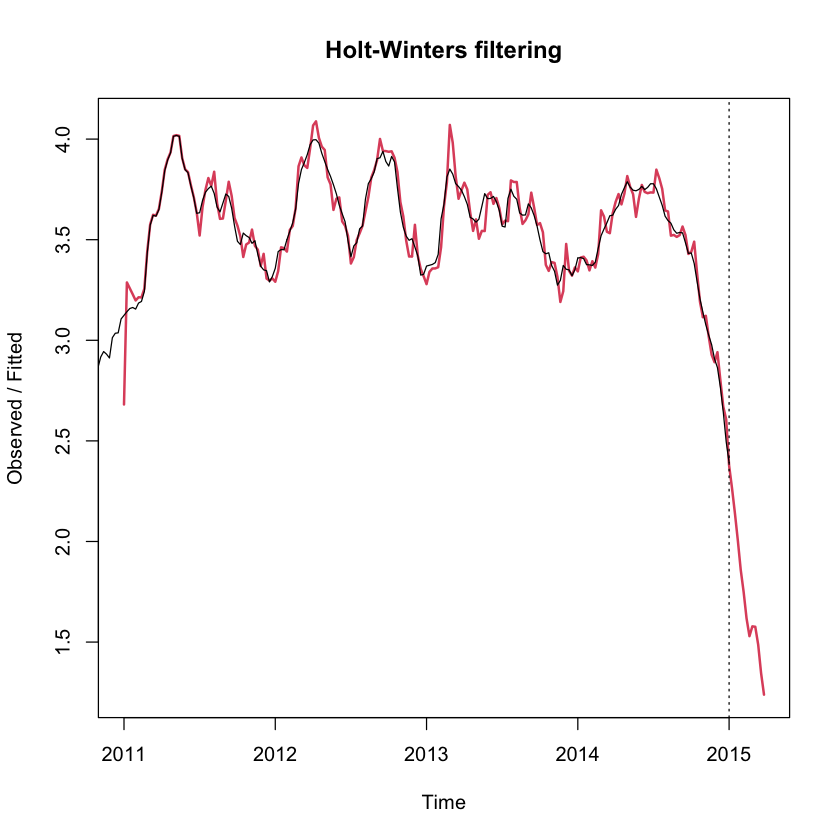

In [175]:
m3 <- HoltWinters(ts, seasonal = 'multiplicative')
f3 <- predict(m3, n.ahead = 12)
plot(m3, predicted.values = f3, lwd = 2)
m4 <- HoltWinters(ts, seasonal = 'additive')
f4 <- predict(m4, n.ahead = 12)
plot(m4, predicted.values = f4, lwd = 2)